In [2]:
import pandas as pd
import numpy as np

df1=pd.read_csv('C:/Users/Thoma/OneDrive/Desktop/EnglishDatasets/2016-17.csv',usecols=['HomeTeam','AwayTeam','FTHG','FTAG',
'FTR','HS','AS','HST','AST','B365H','B365D','B365A'])
df1.head()



,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A
0,Burnley,Swansea,0,1,A,10,17,3,9,2.40,3.3,3.25
1,Crystal Palace,West Brom,0,1,A,14,13,4,3,2.00,3.3,4.50
2,Everton,Tottenham,1,1,D,12,13,6,4,3.20,3.4,2.40
3,Hull,Leicester,2,1,H,14,18,5,5,4.50,3.6,1.91
4,Man City,Sunderland,2,1,H,16,7,4,3,1.25,6.5,15.00


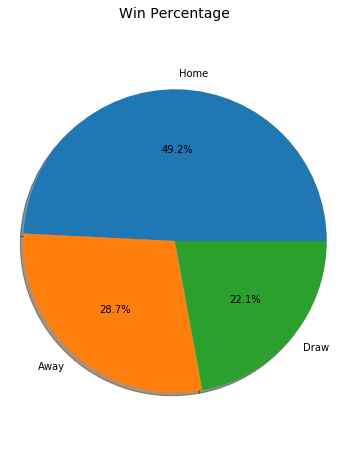

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,8))
plt.pie(df1['FTR'].value_counts(),labels=['Home','Away','Draw'], autopct='%1.1f%%',shadow=True, startangle=0)
plt.axis('equal')
plt.title('Win Percentage', size=14)
plt.show()

In [11]:
from statsmodels.stats import proportion
conf=proportion.proportion_confint((df1['FTR']=='H').sum(), df1['FTR'].count(), alpha=0.05, method='normal')
print('The chance of home team to win with %95 confidence interval falls in :{}'.format(conf))

The chance of home team to win with %95 confidence interval falls in :(0.441839514668131, 0.5423710116476584)


In [12]:

dfSq=pd.read_csv('C:/Users/Thoma/OneDrive/Desktop/EnglishDatasets/2016-17S.csv',index_col='Team').dropna(axis=0,how='any')

dfSq.head()
dff=df1.join(dfSq[['Hde','Hatt','Hpo','Htot']],on='HomeTeam')
df=dff.join(dfSq[['Ade','Aatt','Apo','Atot']],on='AwayTeam')

In [73]:
def make_data(df):
    ##add points for away and home team : win 3 points, draw 1 point, loss 0 point
    df['HP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[3,1,0])
    df['AP']=np.select([df['FTR']=='H',df['FTR']=='D',df['FTR']=='A'],[0,1,3])
    ## add difference in goals for home and away team
    df['HDG']=df['FTHG']-df['FTAG']
    df['ADG']=-df['FTHG']+df['FTAG']
    ##add momentum to data 
    cols=['Team','Points','Goal','Shoot','TargetShoot','DiffG']
    df1=df[['HomeTeam','AwayTeam','HP','AP','FTHG','FTAG','HS','AS','HST','AST','HDG','ADG']]
    df1.columns=[np.repeat(cols,2),['Home','Away']*len(cols)]
    d1=df1.stack()
    ##find momentum of previous five games for each team
    mom5 = d1.groupby('Team').apply(lambda x: x.shift().rolling(5, 4).mean())
    mom=d1.groupby('Team').apply(lambda x: x.shift().expanding(0).mean())
    ##add the found momentum to the dataframe
    df2=d1.assign(MP=mom5['Points'],MG=mom5['Goal'],MS=mom5['Shoot'],MST=mom5['TargetShoot'],MDG=mom5['DiffG'],AP=mom['Points'],AG=mom['Goal'],AS=mom['Shoot'],AST=mom['TargetShoot'],ADG=mom['DiffG']).unstack()
    df2=df2.drop(['Points','Goal','Shoot','TargetShoot','DiffG'],axis=1)
    df_final=pd.merge(df[['HomeTeam','AwayTeam','FTR','B365H','B365D','B365A','Ade','Aatt','Apo','Atot','Hde','Hatt','Hpo','Htot']],df2,left_on=['HomeTeam','AwayTeam'],right_on=[df2['Team']['Home'],df2['Team']['Away']])
    df_final=df_final.dropna(axis=0,how='any')
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    Y_all=df_final['FTR']
    ##Full time results ('FTR') : Home=0,Draw=1,Away=2
    ##Prediction of betting company (bet365)=Y_Bet
    Y_Bet=df_final[['B365H','B365D','B365A']].apply(lambda x:1/x)
    
    Y_Bet_FTR=np.select([Y_Bet.idxmax(axis=1)=='B365H',Y_Bet.idxmax(axis=1)=='B365D',Y_Bet.idxmax(axis=1)=='B365A'],['H','D'
    ,'A'])
 
    df_X=df_final.drop([('Team', 'Home'),('Team', 'Away'),'FTR','HomeTeam','AwayTeam','B365H','B365D','B365A'],axis=1)
    return df_X, Y_all,Y_Bet,Y_Bet_FTR
df_X, Y_all,Y_Bet,Y_Bet_FTR=make_data(df)

In [74]:
from sklearn.preprocessing import scale
X_all=scale(df_X)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import classification_report
def data_split(X_all, Y_all,Y_Bet_FTR,Y_Bet):
    X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet = train_test_split(X_all, Y_all,
    Y_Bet_FTR,Y_Bet, test_size=0.3, random_state=42) 
    return X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet  
def predict_labels(clf,X_test):
    y_pred=clf.predict(X_test)
    return y_pred   
def report_score(clf,X_test,y_test,y_pred,X_train,y_train):
    target_names = ['H', 'D', 'A']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print ('{}....Test accuracy:{} Train accuracy:{}'.format(clf.__class__.__name__,clf.score(X_test,y_test),
    clf.score(X_train,y_train)))
def report_score_bet365(y_test,y_pred):
    target_names = ['H', 'D', 'A']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print ('BET365 accuracy:{} '.format((y_test==y_pred).sum()/len(y_test)))
def train_classifier(clf,parameters,X_train,y_train):
    grid_class = GridSearchCV(clf,scoring='accuracy',param_grid=parameters)
    grid_class = grid_class.fit(X_train,y_train)
    clf = grid_class.best_estimator_
    return clf
clf_logistic= linear_model.LogisticRegression(multi_class = "ovr", solver = 'newton-cg', class_weight = 'balanced')
clf_svc = SVC(kernel="linear",probability=True)
clfs=[clf_logistic,clf_svc]
X_train, X_test, y_train, y_test,y_train_bet_FTR,y_test_bet_FTR,y_train_bet,y_test_bet=data_split(X_all, Y_all,Y_Bet_FTR,Y_Bet)
parameter_logistic = {'C': np.logspace(-5,5,100)}
parameter_SVC = {'C': np.arange(0.1,3,0.01)}
parameters={clfs[0]:parameter_logistic,clfs[1]:parameter_SVC}

In [77]:
for clf in clfs:
    clf=train_classifier(clf,parameters[clf],X_train,y_train)
    y_pred=predict_labels(clf,X_test)
    report_score(clf,X_test,y_test,y_pred,X_train,y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           H       0.49      0.71      0.58        28
           D       0.25      0.15      0.19        20
           A       0.71      0.65      0.68        54

    accuracy                           0.57       102
   macro avg       0.48      0.50      0.48       102
weighted avg       0.56      0.57      0.56       102

LogisticRegression....Test accuracy:0.5686274509803921 Train accuracy:0.6428571428571429
              precision    recall  f1-score   support

           H       0.59      0.61      0.60        28
           D       0.50      0.15      0.23        20
           A       0.64      0.80      0.71        54

    accuracy                           0.62       102
   macro avg       0.58      0.52      0.51       102
weighted avg       0.60      0.62      0.59       102

SVC....Test accuracy:0.6176470588235294 Train accuracy:0.6764705882352942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [79]:
for clf in clfs:
    clf=train_classifier(clf,parameters[clf],X_train,y_train)
    y_pred=predict_labels(clf,X_test)
report_score_bet365(y_test,y_test_bet_FTR)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


              precision    recall  f1-score   support

           H       0.60      0.75      0.67        28
           D       0.00      0.00      0.00        20
           A       0.67      0.83      0.74        54

    accuracy                           0.65       102
   macro avg       0.42      0.53      0.47       102
weighted avg       0.52      0.65      0.58       102

BET365 accuracy:0.6470588235294118 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
